In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from torch import nn
from pyro.nn import PyroSample

# Définition du modèle bayésien
class BayesianNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x_data):
        x_data = torch.relu(self.fc1(x_data))
        x_data = self.fc2(x_data)
        return x_data

def model(x_data, y_data):
    bnn = BayesianNN()
    with pyro.plate("data", x_data.shape[0]):
        # Définition des priors pour les poids et les biais
        fc1_weight = pyro.sample("fc1_weight", dist.Normal(torch.zeros_like(bnn.fc1.weight), torch.ones_like(bnn.fc1.weight)).to_event(2))
        fc1_bias = pyro.sample("fc1_bias", dist.Normal(torch.zeros_like(bnn.fc1.bias), torch.ones_like(bnn.fc1.bias)).to_event(1))
        fc2_weight = pyro.sample("fc2_weight", dist.Normal(torch.zeros_like(bnn.fc2.weight), torch.ones_like(bnn.fc2.weight)).to_event(2))
        fc2_bias = pyro.sample("fc2_bias", dist.Normal(torch.zeros_like(bnn.fc2.bias), torch.ones_like(bnn.fc2.bias)).to_event(1))

        bnn.fc1.weight = nn.Parameter(fc1_weight)
        bnn.fc1.bias = nn.Parameter(fc1_bias)
        bnn.fc2.weight = nn.Parameter(fc2_weight)
        bnn.fc2.bias = nn.Parameter(fc2_bias)

        # Passer les données à travers le modèle
        logits = bnn(x_data)
        with pyro.plate("data_plate", x_data.shape[0]):
            pyro.sample("obs", dist.Bernoulli(logits=logits).to_event(1), obs=y_data)

def guide(x_data, y_data=None):
    bnn = BayesianNN()
    
    # Paramétrisation des poids avec des distributions normales
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.zeros_like(bnn.fc1.weight))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones_like(bnn.fc1.weight), constraint=dist.constraints.positive)
    fc1_bias_mu = pyro.param("fc1_bias_mu", torch.zeros_like(bnn.fc1.bias))
    fc1_bias_sigma = pyro.param("fc1_bias_sigma", torch.ones_like(bnn.fc1.bias), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.zeros_like(bnn.fc2.weight))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones_like(bnn.fc2.weight), constraint=dist.constraints.positive)
    fc2_bias_mu = pyro.param("fc2_bias_mu", torch.zeros_like(bnn.fc2.bias))
    fc2_bias_sigma = pyro.param("fc2_bias_sigma", torch.ones_like(bnn.fc2.bias), constraint=dist.constraints.positive)

    # Sample des poids et des biais
    with pyro.plate("fc1_weight_plate"):
        pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    with pyro.plate("fc1_bias_plate"):
        pyro.sample("fc1_bias", dist.Normal(fc1_bias_mu, fc1_bias_sigma).to_event(1))
    with pyro.plate("fc2_weight_plate"):
        pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))
    with pyro.plate("fc2_bias_plate"):
        pyro.sample("fc2_bias", dist.Normal(fc2_bias_mu, fc2_bias_sigma).to_event(1))

# Initialisation des données
x_data = torch.tensor([[0., 1., 0.], [1., 0., 1.], [1., 1., 1.], [0., 0., 1.]])
y_data = torch.tensor([0, 1, 1, 0], dtype=torch.float)

# Définir l'optimiseur et le SVI
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Vérification des résultats
print("Posterior samples:")
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.mean(dim=0)}")


ValueError: Model and guide shapes disagree at site 'fc1_bias': torch.Size([4, 5]) vs torch.Size([5])

In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour extraire les échantillons des poids
def extract_weights_from_guide(guide, num_samples=1000):
    samples_fc1 = []
    samples_fc2 = []
    for _ in range(num_samples):
        # Effectuer un échantillonnage à partir du guide
        with pyro.plate("data", x_data.size(0)):
            guide(x_data, y_data)
            fc1_weight_sample = pyro.get_param_store().get("fc1_weight_mu") + \
                                pyro.get_param_store().get("fc1_weight_sigma") * torch.randn_like(pyro.get_param_store().get("fc1_weight_sigma"))
            fc2_weight_sample = pyro.get_param_store().get("fc2_weight_mu") + \
                                pyro.get_param_store().get("fc2_weight_sigma") * torch.randn_like(pyro.get_param_store().get("fc2_weight_sigma"))
            samples_fc1.append(fc1_weight_sample.detach().numpy())
            samples_fc2.append(fc2_weight_sample.detach().numpy())
    return np.array(samples_fc1), np.array(samples_fc2)

# Extraire les échantillons des poids
fc1_weight_samples, fc2_weight_samples = extract_weights_from_guide(guide)

# Visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


C:\Users\YM278243\AppData\Local\anaconda3\Lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'fc1_weight', 'fc2_weight'}
  warnings.warn(


Step 0, Loss: -30.9626


C:\Users\YM278243\AppData\Local\anaconda3\Lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'fc1_weight', 'fc2_weight'}
  warnings.warn(


Step 100, Loss: -54.9070
Step 200, Loss: -84.9393
Step 300, Loss: -102.2021
Step 400, Loss: -124.6691
Step 500, Loss: -154.2968
Step 600, Loss: -180.3995
Step 700, Loss: -208.0967
Step 800, Loss: -232.0413
Step 900, Loss: -246.5886


AttributeError: 'ParamStoreDict' object has no attribute 'get'

In [5]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour extraire les échantillons des poids
def extract_weights_from_guide(num_samples=1000):
    samples_fc1 = []
    samples_fc2 = []
    for _ in range(num_samples):
        # Effectuer un échantillonnage à partir du guide
        with pyro.plate("data", x_data.size(0)):
            guide(x_data, y_data)
            fc1_weight_mu = pyro.get_param_store().get("fc1_weight_mu")
            fc1_weight_sigma = pyro.get_param_store().get("fc1_weight_sigma")
            fc2_weight_mu = pyro.get_param_store().get("fc2_weight_mu")
            fc2_weight_sigma = pyro.get_param_store().get("fc2_weight_sigma")
            
            # Échantillonnage des poids
            fc1_weight_sample = fc1_weight_mu + fc1_weight_sigma * torch.randn_like(fc1_weight_sigma)
            fc2_weight_sample = fc2_weight_mu + fc2_weight_sigma * torch.randn_like(fc2_weight_sigma)
            
            samples_fc1.append(fc1_weight_sample.detach().numpy())
            samples_fc2.append(fc2_weight_sample.detach().numpy())
    return np.array(samples_fc1), np.array(samples_fc2)

# Extraire les échantillons des poids
fc1_weight_samples, fc2_weight_samples = extract_weights_from_guide()

# Visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


Step 0, Loss: -281.5442
Step 100, Loss: -298.8530
Step 200, Loss: -330.1839
Step 300, Loss: -350.0675
Step 400, Loss: -375.8781
Step 500, Loss: -406.0462
Step 600, Loss: -427.6337
Step 700, Loss: -454.3139
Step 800, Loss: -482.9686
Step 900, Loss: -502.8219


AttributeError: 'ParamStoreDict' object has no attribute 'get'

In [7]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour extraire les échantillons des poids
def extract_weights_from_guide(num_samples=1000):
    samples_fc1 = []
    samples_fc2 = []
    param_store = pyro.get_param_store().params
    
    for _ in range(num_samples):
        # Effectuer un échantillonnage à partir du guide
        with pyro.plate("data", x_data.size(0)):
            guide(x_data, y_data)
            fc1_weight_mu = param_store["fc1_weight_mu"]
            fc1_weight_sigma = param_store["fc1_weight_sigma"]
            fc2_weight_mu = param_store["fc2_weight_mu"]
            fc2_weight_sigma = param_store["fc2_weight_sigma"]
            
            # Échantillonnage des poids
            fc1_weight_sample = fc1_weight_mu + fc1_weight_sigma * torch.randn_like(fc1_weight_sigma)
            fc2_weight_sample = fc2_weight_mu + fc2_weight_sigma * torch.randn_like(fc2_weight_sigma)
            
            samples_fc1.append(fc1_weight_sample.detach().numpy())
            samples_fc2.append(fc2_weight_sample.detach().numpy())
    return np.array(samples_fc1), np.array(samples_fc2)

# Extraire les échantillons des poids
fc1_weight_samples, fc2_weight_samples = extract_weights_from_guide()

# Visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


Step 0, Loss: -530.8075
Step 100, Loss: -551.6043
Step 200, Loss: -584.5918
Step 300, Loss: -605.9870
Step 400, Loss: -628.6885
Step 500, Loss: -658.5067
Step 600, Loss: -678.5863
Step 700, Loss: -704.1488
Step 800, Loss: -730.8854
Step 900, Loss: -754.7593


AttributeError: 'ParamStoreDict' object has no attribute 'params'

Step 0, Loss: -780.9084
Step 100, Loss: -807.6417
Step 200, Loss: -827.6769
Step 300, Loss: -862.2951
Step 400, Loss: -876.9064
Step 500, Loss: -901.8283
Step 600, Loss: -926.2117
Step 700, Loss: -953.3668
Step 800, Loss: -978.8808
Step 900, Loss: -1000.6870


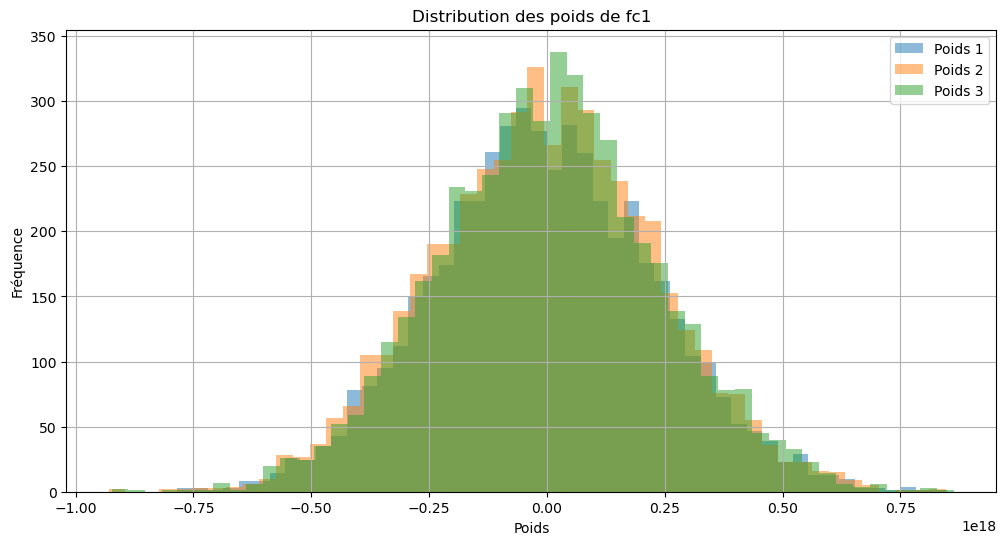

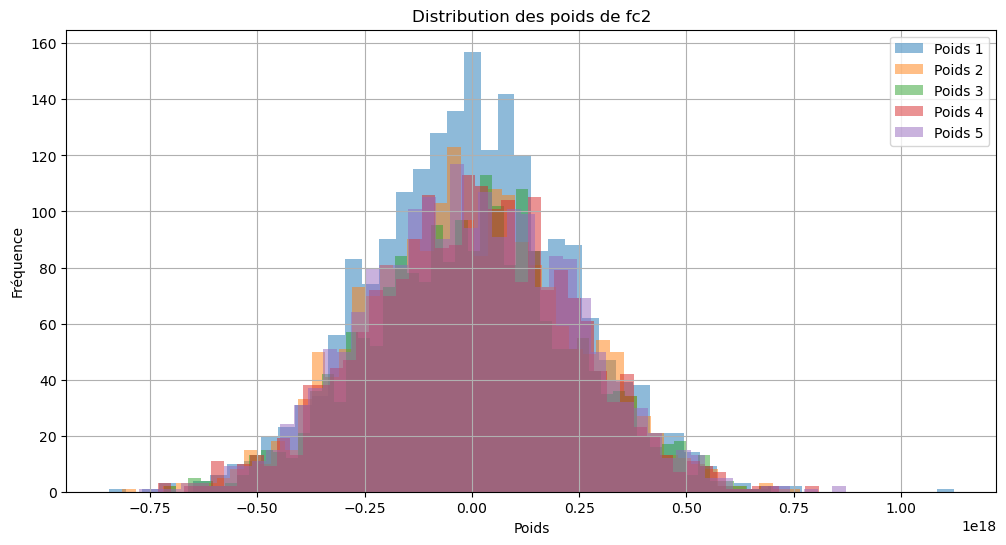

In [9]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour extraire les échantillons des poids
def extract_weights_from_guide(num_samples=1000):
    samples_fc1 = []
    samples_fc2 = []
    
    for _ in range(num_samples):
        # Effectuer un échantillonnage à partir du guide
        guide(x_data, y_data)
        param_store = pyro.get_param_store()
        
        fc1_weight_mu = param_store["fc1_weight_mu"]
        fc1_weight_sigma = param_store["fc1_weight_sigma"]
        fc2_weight_mu = param_store["fc2_weight_mu"]
        fc2_weight_sigma = param_store["fc2_weight_sigma"]
        
        # Échantillonnage des poids
        fc1_weight_sample = fc1_weight_mu + fc1_weight_sigma * torch.randn_like(fc1_weight_sigma)
        fc2_weight_sample = fc2_weight_mu + fc2_weight_sigma * torch.randn_like(fc2_weight_sigma)
        
        samples_fc1.append(fc1_weight_sample.detach().numpy())
        samples_fc2.append(fc2_weight_sample.detach().numpy())
    
    return np.array(samples_fc1), np.array(samples_fc2)

# Extraire les échantillons des poids
fc1_weight_samples, fc2_weight_samples = extract_weights_from_guide()

# Visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


In [2]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour obtenir les paramètres des distributions des poids
def get_distribution_parameters():
    param_store = pyro.get_param_store()
    fc1_weight_mu = param_store["fc1_weight_mu"]
    fc1_weight_sigma = param_store["fc1_weight_sigma"]
    fc2_weight_mu = param_store["fc2_weight_mu"]
    fc2_weight_sigma = param_store["fc2_weight_sigma"]
    
    return fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma

# Extraire et afficher les paramètres
fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma = get_distribution_parameters()

print("fc1_weight_mu:")
print(fc1_weight_mu)
print("fc1_weight_sigma:")
print(fc1_weight_sigma)
print("fc2_weight_mu:")
print(fc2_weight_mu)
print("fc2_weight_sigma:")
print(fc2_weight_sigma)


NameError: name 'nn' is not defined

In [4]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour obtenir les paramètres des distributions des poids
def get_distribution_parameters():
    param_store = pyro.get_param_store()
    fc1_weight_mu = param_store["fc1_weight_mu"]
    fc1_weight_sigma = param_store["fc1_weight_sigma"]
    fc2_weight_mu = param_store["fc2_weight_mu"]
    fc2_weight_sigma = param_store["fc2_weight_sigma"]
    
    return fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma

# Extraire et afficher les paramètres
fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma = get_distribution_parameters()

print("fc1_weight_mu:")
print(fc1_weight_mu)
print("fc1_weight_sigma:")
print(fc1_weight_sigma)
print("fc2_weight_mu:")
print(fc2_weight_mu)
print("fc2_weight_sigma:")
print(fc2_weight_sigma)


C:\Users\YM278243\AppData\Local\anaconda3\Lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'fc2_weight', 'fc1_weight'}
  warnings.warn(


Step 0, Loss: -29.5154


C:\Users\YM278243\AppData\Local\anaconda3\Lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'fc2_weight', 'fc1_weight'}
  warnings.warn(


Step 100, Loss: -56.2715
Step 200, Loss: -82.9920
Step 300, Loss: -101.5383
Step 400, Loss: -129.0569
Step 500, Loss: -158.7776
Step 600, Loss: -182.2735
Step 700, Loss: -202.5644
Step 800, Loss: -234.0784
Step 900, Loss: -262.1579
fc1_weight_mu:
tensor([[ 1.1571,  0.1790,  0.6691],
        [-0.1542,  0.5268,  0.0947],
        [ 0.8270, -0.8253,  2.1221],
        [ 0.5737, -0.6308, -1.0325],
        [ 0.1524, -0.2775,  0.6715]], requires_grad=True)
fc1_weight_sigma:
tensor([[22029.4062, 22029.4062, 22029.4062],
        [22029.4062, 22029.4062, 22029.4062],
        [22029.4062, 22029.4062, 22029.4062],
        [22029.4062, 22029.4062, 22029.4062],
        [22029.4062, 22029.4062, 22029.4062]], grad_fn=<AddBackward0>)
fc2_weight_mu:
tensor([[-1.2711,  0.4352, -1.3530,  0.4750, -0.0504],
        [ 0.9707, -0.7883,  0.1232,  0.5713,  0.7500]], requires_grad=True)
fc2_weight_sigma:
tensor([[22029.4062, 22029.4062, 22029.4062, 22029.4062, 22029.4062],
        [22029.4062, 22029.4062, 22029.4

In [6]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour extraire les échantillons des poids
def extract_weights_from_guide(num_samples=1000):
    samples_fc1 = []
    samples_fc2 = []
    
    # Extraire les paramètres des distributions
    param_store = pyro.get_param_store()
    fc1_weight_mu = param_store["fc1_weight_mu"]
    fc1_weight_sigma = param_store["fc1_weight_sigma"]
    fc2_weight_mu = param_store["fc2_weight_mu"]
    fc2_weight_sigma = param_store["fc2_weight_sigma"]
    
    for _ in range(num_samples):
        # Échantillonnage des poids
        fc1_weight_sample = fc1_weight_mu + fc1_weight_sigma * torch.randn_like(fc1_weight_sigma)
        fc2_weight_sample = fc2_weight_mu + fc2_weight_sigma * torch.randn_like(fc2_weight_sigma)
        
        samples_fc1.append(fc1_weight_sample.detach().numpy())
        samples_fc2.append(fc2_weight_sample.detach().numpy


SyntaxError: incomplete input (2955474521.py, line 76)

Step 0, Loss: -272.3400
Step 100, Loss: -304.7461
Step 200, Loss: -333.0466
Step 300, Loss: -354.3925
Step 400, Loss: -375.9264
Step 500, Loss: -401.6803
Step 600, Loss: -424.8187
Step 700, Loss: -451.8004
Step 800, Loss: -485.9687
Step 900, Loss: -503.9151


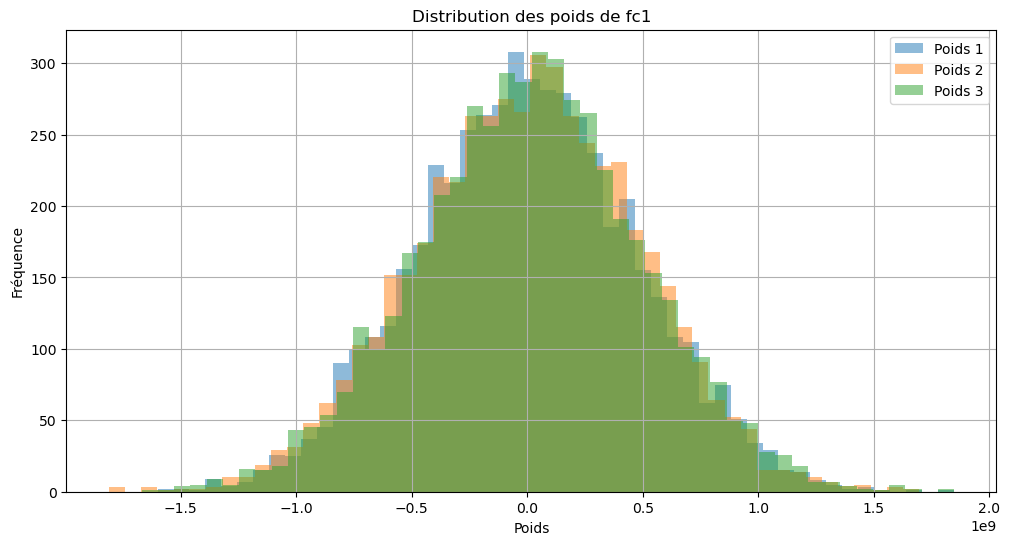

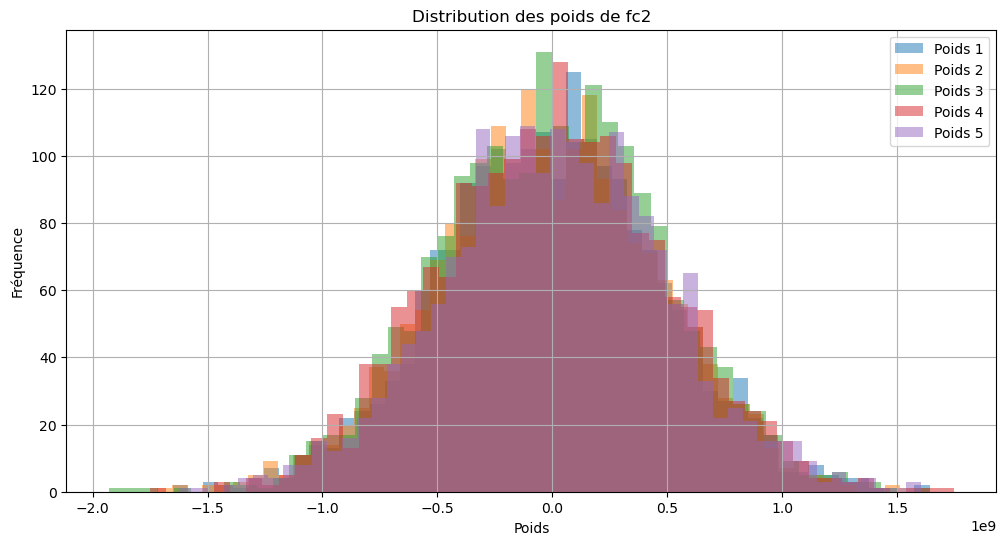

In [8]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour extraire les échantillons des poids
def extract_weights_from_guide(num_samples=1000):
    samples_fc1 = []
    samples_fc2 = []
    
    # Extraire les paramètres des distributions
    param_store = pyro.get_param_store()
    fc1_weight_mu = param_store["fc1_weight_mu"]
    fc1_weight_sigma = param_store["fc1_weight_sigma"]
    fc2_weight_mu = param_store["fc2_weight_mu"]
    fc2_weight_sigma = param_store["fc2_weight_sigma"]
    
    for _ in range(num_samples):
        # Échantillonnage des poids
        fc1_weight_sample = fc1_weight_mu + fc1_weight_sigma * torch.randn_like(fc1_weight_sigma)
        fc2_weight_sample = fc2_weight_mu + fc2_weight_sigma * torch.randn_like(fc2_weight_sigma)
        
        samples_fc1.append(fc1_weight_sample.detach().numpy())
        samples_fc2.append(fc2_weight_sample.detach().numpy())
    
    return np.array(samples_fc1), np.array(samples_fc2)

# Extraire les échantillons des poids
fc1_weight_samples, fc2_weight_samples = extract_weights_from_guide()

# Visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


In [10]:
        samples_fc2.append(fc2_weight_sample.detach().numpy())
    
    return np.array(samples_fc1), np.array(samples_fc2)

# Extraire les échantillons des poids
fc1_weight_samples, fc2_weight_samples = extract_weights_from_guide()

# Visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


IndentationError: unexpected indent (2417419441.py, line 3)

Step 0, Loss: -527.6271
Step 100, Loss: -554.7960
Step 200, Loss: -580.2150
Step 300, Loss: -598.0055
Step 400, Loss: -628.8412
Step 500, Loss: -660.1977
Step 600, Loss: -684.0163
Step 700, Loss: -711.2012
Step 800, Loss: -731.0075
Step 900, Loss: -753.5773


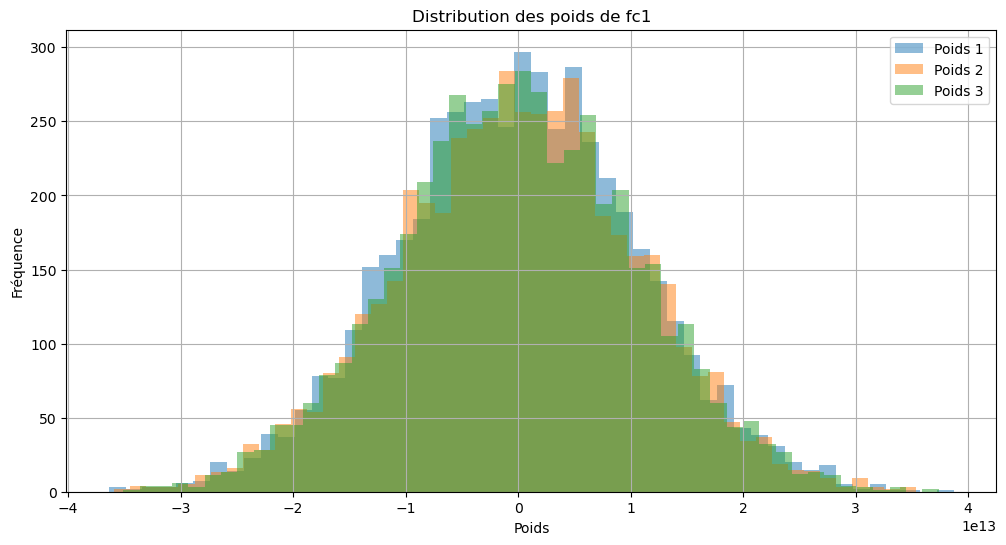

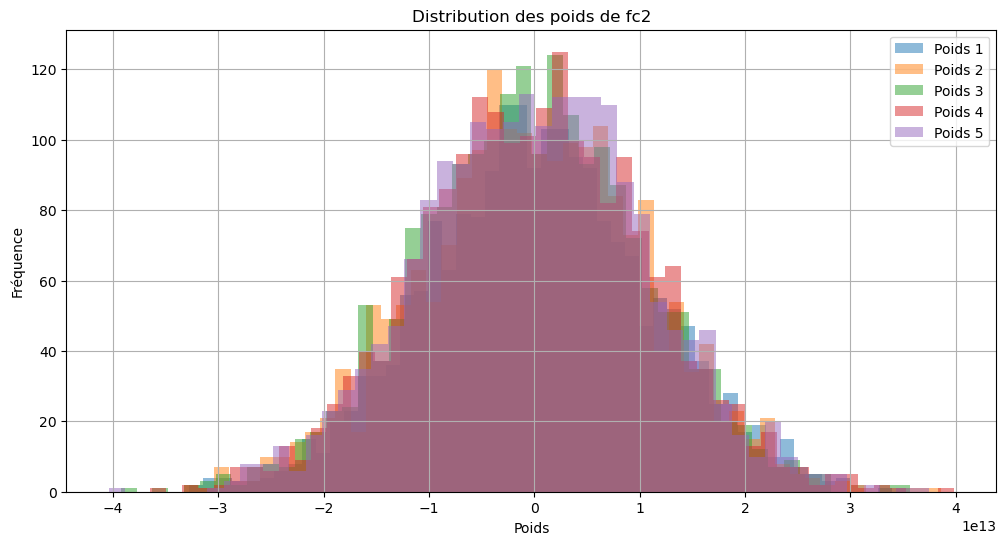

In [12]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Fonction pour extraire les échantillons des poids
def extract_weights_from_guide(num_samples=1000):
    samples_fc1 = []
    samples_fc2 = []
    
    # Extraire les paramètres des distributions
    param_store = pyro.get_param_store()
    fc1_weight_mu = param_store["fc1_weight_mu"]
    fc1_weight_sigma = param_store["fc1_weight_sigma"]
    fc2_weight_mu = param_store["fc2_weight_mu"]
    fc2_weight_sigma = param_store["fc2_weight_sigma"]
    
    for _ in range(num_samples):
        # Échantillonnage des poids
        fc1_weight_sample = fc1_weight_mu + fc1_weight_sigma * torch.randn_like(fc1_weight_sigma)
        fc2_weight_sample = fc2_weight_mu + fc2_weight_sigma * torch.randn_like(fc2_weight_sigma)
        
        samples_fc1.append(fc1_weight_sample.detach().numpy())
        samples_fc2.append(fc2_weight_sample.detach().numpy())
    
    return np.array(samples_fc1), np.array(samples_fc2)

# Extraire les échantillons des poids
fc1_weight_samples, fc2_weight_samples = extract_weights_from_guide()

# Visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


In [2]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée factices
#x_data = torch.randn(4, 3)  # 4 échantillons, chacun avec 3 caractéristiques
#y_data = torch.randint(0, 2, (4, 2)).float()  # 4 échantillons, chacun avec 2 sorties binaires

x_data = torch.tensor([[1, 1, 1],  # Fortes migraines, toux, fatigue (COVID-19)
                       [0, 1, 1],  # Toux, fatigue (grippe)
                       [1, 0, 0],  # Migraines seulement (probablement pas de maladie)
                       [1, 1, 0]])  # Migraines et toux (potentiellement grippe ou COVID-19)

y_data = torch.tensor([[0, 1],  # COVID-19
                       [1, 0],  # Grippe
                       [1, 0],  # Grippe
                       [0, 1]])  # COVID-19


# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Extraction des matrices des poids de la moyenne et de l'écart type
def extract_weight_parameters():
    param_store = pyro.get_param_store()
    
    fc1_weight_mu = param_store["fc1_weight_mu"].detach().numpy()
    fc1_weight_sigma = param_store["fc1_weight_sigma"].detach().numpy()
    fc2_weight_mu = param_store["fc2_weight_mu"].detach().numpy()
    fc2_weight_sigma = param_store["fc2_weight_sigma"].detach().numpy()
    
    return fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma

# Extraire les paramètres des poids
fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma = extract_weight_parameters()

# Afficher les matrices des poids de la moyenne et de l'écart type
print("Matrice des moyennes des poids de fc1:")
print(fc1_weight_mu)
print("\nMatrice des écarts types des poids de fc1:")
print(fc1_weight_sigma)
print("\nMatrice des moyennes des poids de fc2:")
print(fc2_weight_mu)
print("\nMatrice des écarts types des poids de fc2:")
print(fc2_weight_sigma)

# Fonction pour visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float
Trace Shapes:    
 Param Sites:    
Sample Sites:    
    data dist   |
        value 4 |

In [4]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée basées sur des symptômes réels
# Symptômes : [migraines, toux, fatigue] (1 = présent, 0 = absent)
x_data = torch.tensor([[1, 1, 1],  # Fortes migraines, toux, fatigue (COVID-19)
                       [0, 1, 1],  # Toux, fatigue (grippe)
                       [1, 0, 0],  # Migraines seulement (probablement pas de maladie)
                       [1, 1, 0]])  # Migraines et toux (potentiellement grippe ou COVID-19)

# Étiquettes de sortie (grippe = [1, 0], COVID-19 = [0, 1])
y_data = torch.tensor([[0, 1],  # COVID-19
                       [1, 0],  # Grippe
                       [1, 0],  # Grippe
                       [0, 1]])  # COVID-19

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Extraction des matrices des poids de la moyenne et de l'écart type
def extract_weight_parameters():
    param_store = pyro.get_param_store()
    
    fc1_weight_mu = param_store["fc1_weight_mu"].detach().numpy()
    fc1_weight_sigma = param_store["fc1_weight_sigma"].detach().numpy()
    fc2_weight_mu = param_store["fc2_weight_mu"].detach().numpy()
    fc2_weight_sigma = param_store["fc2_weight_sigma"].detach().numpy()
    
    return fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma

# Extraire les paramètres des poids
fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma = extract_weight_parameters()

# Afficher les matrices des poids de la moyenne et de l'écart type
print("Matrice des moyennes des poids de fc1:")
print(fc1_weight_mu)
print("\nMatrice des écarts types des poids de fc1:")
print(fc1_weight_sigma)
print("\nMatrice des moyennes des poids de fc2:")
print(fc2_weight_mu)
print("\nMatrice des écarts types des poids de fc2:")
print(fc2_weight_sigma)

# Fonction pour visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Pour visualiser les poids, tu devras d'abord échantillonner un ensemble de poids
fc1_weight_samples = dist.Normal(torch.tensor(fc1_weight_mu), torch.tensor(fc1_weight_sigma)).sample([100])
fc2_weight_samples = dist.Normal(torch.tensor(fc2_weight_mu), torch.tensor(fc2_weight_sigma)).sample([100])

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float
Trace Shapes:    
 Param Sites:    
Sample Sites:    
    data dist   |
        value 4 |

C:\Users\YM278243\AppData\Local\anaconda3\Lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'fc2_weight', 'fc1_weight'}
  warnings.warn(


Step 0, Loss: -34.2169


C:\Users\YM278243\AppData\Local\anaconda3\Lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'fc2_weight', 'fc1_weight'}
  warnings.warn(


Step 100, Loss: -50.9411
Step 200, Loss: -81.1600
Step 300, Loss: -105.4521
Step 400, Loss: -126.0130
Step 500, Loss: -150.5363
Step 600, Loss: -184.3754
Step 700, Loss: -208.5242
Step 800, Loss: -230.7605
Step 900, Loss: -254.1655
Matrice des moyennes des poids de fc1:
[[ 0.12292238  1.2341915  -1.3027638 ]
 [-0.27358758 -1.1178864   1.101809  ]
 [ 1.4348171   0.26843718 -0.6839911 ]
 [ 0.41504592 -0.3927248   1.7648363 ]
 [ 0.78518176  3.0586634  -1.0943631 ]]

Matrice des écarts types des poids de fc1:
[[22029.406 22029.406 22029.406]
 [22029.406 22029.406 22029.406]
 [22029.406 22029.406 22029.406]
 [22029.406 22029.406 22029.406]
 [22029.406 22029.406 22029.406]]

Matrice des moyennes des poids de fc2:
[[ 0.44924867  0.10985921 -1.4033002   0.6517217   1.3437862 ]
 [ 1.3176241  -3.0064125  -0.4002211  -1.0961337   0.1890575 ]]

Matrice des écarts types des poids de fc2:
[[22029.406 22029.406 22029.406 22029.406 22029.406]
 [22029.406 22029.406 22029.406 22029.406 22029.406]]


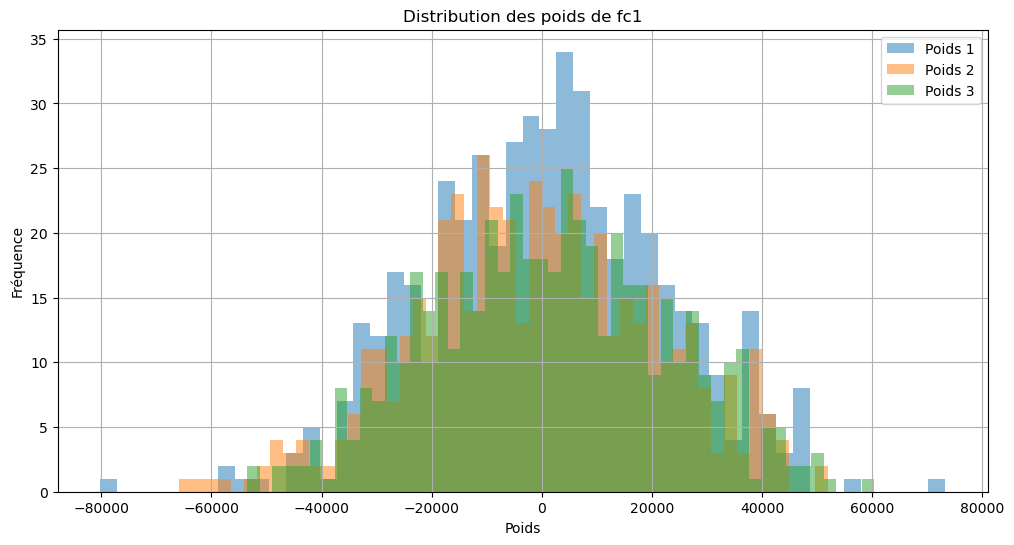

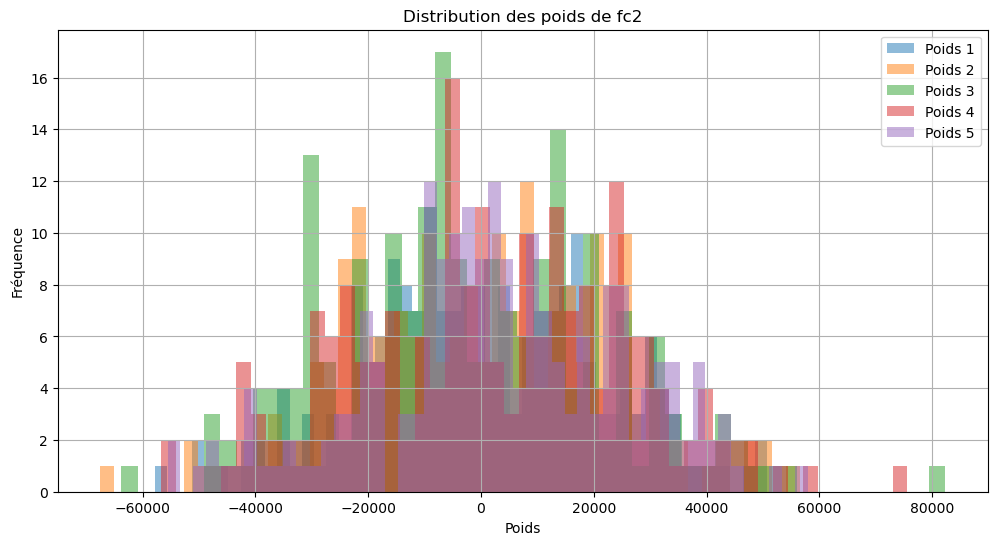

In [6]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Définition d'un réseau neuronal bayésien simple
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Guide : distribution approximative pour les poids bayésiens
def guide(x_data, y_data=None):
    bnn = BayesianNN()
    # Paramétrisation des poids avec des distributions normales pour la variabilité bayésienne
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3), constraint=dist.constraints.positive)
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(2, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(2, 5), constraint=dist.constraints.positive)

    # Sample des poids du modèle
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Modèle probabiliste
def model(x_data, y_data=None):
    bnn = BayesianNN()
    with pyro.plate("data", len(x_data)):  # Gestion des dimensions via plate
        y_pred = bnn(x_data)
        # Échantillonnage des observations avec la bonne forme
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Génération de données d'entrée basées sur des symptômes réels
# Symptômes : [migraines, toux, fatigue] (1 = présent, 0 = absent)
x_data = torch.tensor([[1, 1, 1],  # Fortes migraines, toux, fatigue (COVID-19)
                       [0, 1, 1],  # Toux, fatigue (grippe)
                       [1, 0, 0],  # Migraines seulement (probablement pas de maladie)
                       [1, 1, 0]], dtype=torch.float32)  # Migraines et toux (potentiellement grippe ou COVID-19)

# Étiquettes de sortie (grippe = [1, 0], COVID-19 = [0, 1])
y_data = torch.tensor([[0, 1],  # COVID-19
                       [1, 0],  # Grippe
                       [1, 0],  # Grippe
                       [0, 1]], dtype=torch.float32)  # COVID-19

# Optimisation
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 1000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Extraction des matrices des poids de la moyenne et de l'écart type
def extract_weight_parameters():
    param_store = pyro.get_param_store()
    
    fc1_weight_mu = param_store["fc1_weight_mu"].detach().numpy()
    fc1_weight_sigma = param_store["fc1_weight_sigma"].detach().numpy()
    fc2_weight_mu = param_store["fc2_weight_mu"].detach().numpy()
    fc2_weight_sigma = param_store["fc2_weight_sigma"].detach().numpy()
    
    return fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma

# Extraire les paramètres des poids
fc1_weight_mu, fc1_weight_sigma, fc2_weight_mu, fc2_weight_sigma = extract_weight_parameters()

# Afficher les matrices des poids de la moyenne et de l'écart type
print("Matrice des moyennes des poids de fc1:")
print(fc1_weight_mu)
print("\nMatrice des écarts types des poids de fc1:")
print(fc1_weight_sigma)
print("\nMatrice des moyennes des poids de fc2:")
print(fc2_weight_mu)
print("\nMatrice des écarts types des poids de fc2:")
print(fc2_weight_sigma)

# Fonction pour visualiser la distribution des poids
def plot_weight_distribution(weight_samples, title):
    weight_samples = weight_samples.reshape(-1, weight_samples.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(weight_samples.shape[-1]):
        plt.hist(weight_samples[:, i], bins=50, alpha=0.5, label=f'Poids {i+1}')
    plt.title(title)
    plt.xlabel('Poids')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True)
    plt.show()

# Pour visualiser les poids, tu devras d'abord échantillonner un ensemble de poids
fc1_weight_samples = dist.Normal(torch.tensor(fc1_weight_mu), torch.tensor(fc1_weight_sigma)).sample([100])
fc2_weight_samples = dist.Normal(torch.tensor(fc2_weight_mu), torch.tensor(fc2_weight_sigma)).sample([100])

# Visualiser les poids de fc1
plot_weight_distribution(fc1_weight_samples, 'Distribution des poids de fc1')

# Visualiser les poids de fc2
plot_weight_distribution(fc2_weight_samples, 'Distribution des poids de fc2')


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Définition du réseau de neurones bayésien
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Modèle Pyro
def model(x_data, y_data):
    bnn = BayesianNN()

    # Priors bayésiens pour les poids et biais
    fc1_weight_mu = torch.zeros(5, 3)
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    fc1_weight = pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))

    fc2_weight_mu = torch.zeros(1, 5)
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(1, 5) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    fc2_weight = pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

    # Mise à jour des poids dans le réseau
    bnn.fc1.weight = nn.Parameter(fc1_weight)
    bnn.fc2.weight = nn.Parameter(fc2_weight)

    # Définition de la plaque de données pour la gestion des dimensions
    with pyro.plate("data", len(x_data)):
        y_pred = bnn(x_data)
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Guide (inférence variationnelle)
def guide(x_data, y_data):
    # Paramètres pour fc1
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))

    # Paramètres pour fc2
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(1, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(1, 5) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Données
x_data = torch.tensor([[0.1, 0.2, 0.3],
                       [0.4, 0.5, 0.6],
                       [0.7, 0.8, 0.9],
                       [0.9, 0.7, 0.8]], dtype=torch.float32)

y_data = torch.tensor([[0.0], [1.0], [0.0], [1.0]], dtype=torch.float32)

# Optimiseur et algorithme d'inférence
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 2000
for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")
        print("fc1_weight_sigma:", pyro.param("fc1_weight_sigma").detach().numpy())
        print("fc2_weight_sigma:", pyro.param("fc2_weight_sigma").detach().numpy())


Step 0, Loss: 63.7696
fc1_weight_sigma: [[22248.35  22250.79  22250.748]
 [21810.309 22249.771 21810.33 ]
 [22250.77  21810.725 21810.455]
 [22250.662 21810.559 22250.748]
 [21812.992 21810.227 21810.29 ]]
fc2_weight_sigma: [[22250.492 21810.518 22250.557 22250.684 22250.748]
 [21810.246 21810.246 21810.662 21810.83  21810.393]]
Step 100, Loss: 63.7692
fc1_weight_sigma: [[23205.09  20162.814 20162.508]
 [19367.787 22992.908 25207.678]
 [21241.514 21023.314 22564.254]
 [20603.123 21288.238 23238.617]
 [23976.154 20469.867 22491.508]]
fc2_weight_sigma: [[23834.012 21048.771 24018.951 21042.049 21606.74 ]
 [19429.318 21848.303 21736.7   21641.262 21328.535]]
Step 200, Loss: 63.7701
fc1_weight_sigma: [[18574.377 22647.967 16582.68 ]
 [18718.934 22176.602 26317.088]
 [20444.7   21021.568 22684.13 ]
 [23305.488 19235.86  26179.91 ]
 [27661.678 21486.758 20136.873]]
fc2_weight_sigma: [[23256.975 23304.332 21341.922 17149.404 19364.72 ]
 [22019.64  24039.322 18665.525 20990.078 19990.078]]
Ste

Step 0, Loss: 79.7121
Step 100, Loss: 63.7697
Step 200, Loss: 63.7694
Step 300, Loss: 63.7693
Step 400, Loss: 63.7684
Step 500, Loss: 63.7676
Step 600, Loss: 63.7695
Step 700, Loss: 47.8277
Step 800, Loss: 63.7694
Step 900, Loss: 63.7694
Step 1000, Loss: 63.7682
Step 1100, Loss: 63.7699
Step 1200, Loss: 63.7670
Step 1300, Loss: 63.7699
Step 1400, Loss: 63.7674
Step 1500, Loss: 63.7689
Step 1600, Loss: 47.8283
Step 1700, Loss: 63.7710
Step 1800, Loss: 47.8308
Step 1900, Loss: 63.7721


C:\Users\YM278243\AppData\Local\Temp\ipykernel_19952\3036085803.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  fc1_sigma_history = torch.tensor(fc1_sigma_history).numpy()


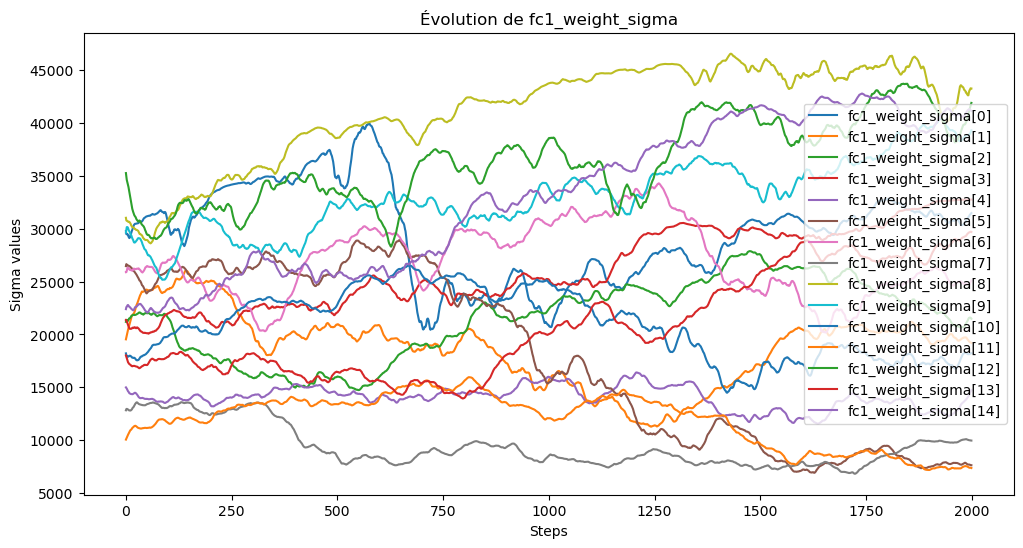

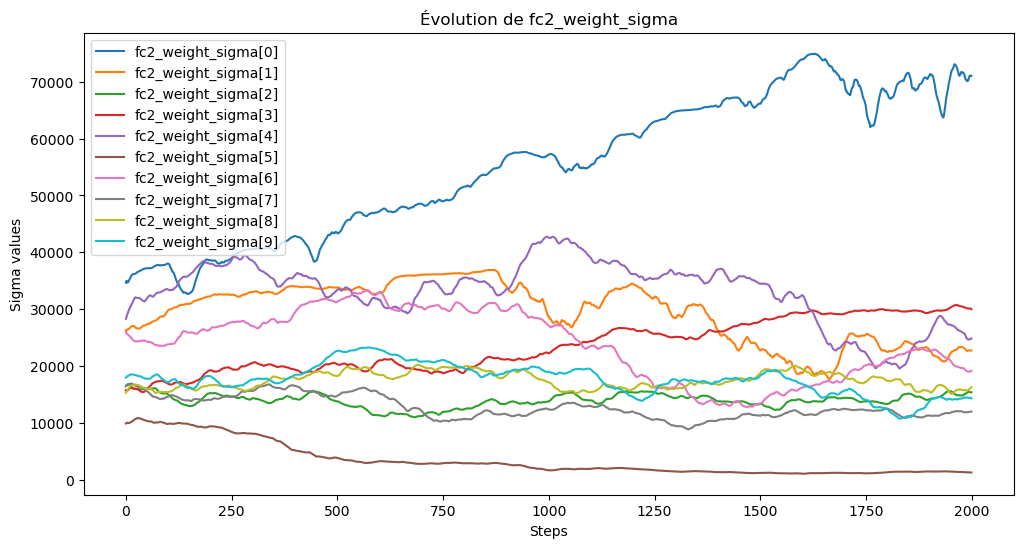

In [10]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

# Définition du réseau de neurones bayésien
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(3, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Modèle Pyro
def model(x_data, y_data):
    bnn = BayesianNN()

    # Priors bayésiens pour les poids et biais
    fc1_weight_mu = torch.zeros(5, 3)
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    fc1_weight = pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))

    fc2_weight_mu = torch.zeros(1, 5)
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(1, 5) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    fc2_weight = pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

    # Mise à jour des poids dans le réseau
    bnn.fc1.weight = nn.Parameter(fc1_weight)
    bnn.fc2.weight = nn.Parameter(fc2_weight)

    # Définition de la plaque de données pour la gestion des dimensions
    with pyro.plate("data", len(x_data)):
        y_pred = bnn(x_data)
        pyro.sample("obs", dist.Bernoulli(y_pred).to_event(1), obs=y_data)

# Guide (inférence variationnelle)
def guide(x_data, y_data):
    # Paramètres pour fc1
    fc1_weight_mu = pyro.param("fc1_weight_mu", torch.randn(5, 3))
    fc1_weight_sigma = pyro.param("fc1_weight_sigma", torch.ones(5, 3) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    pyro.sample("fc1_weight", dist.Normal(fc1_weight_mu, fc1_weight_sigma).to_event(2))

    # Paramètres pour fc2
    fc2_weight_mu = pyro.param("fc2_weight_mu", torch.randn(1, 5))
    fc2_weight_sigma = pyro.param("fc2_weight_sigma", torch.ones(1, 5) * 0.1, constraint=dist.constraints.positive)  # Initialisation plus petite
    pyro.sample("fc2_weight", dist.Normal(fc2_weight_mu, fc2_weight_sigma).to_event(2))

# Données
x_data = torch.tensor([[0.1, 0.2, 0.3],
                       [0.4, 0.5, 0.6],
                       [0.7, 0.8, 0.9],
                       [0.9, 0.7, 0.8]], dtype=torch.float32)

y_data = torch.tensor([[0.0], [1.0], [0.0], [1.0]], dtype=torch.float32)

# Optimiseur et algorithme d'inférence
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Entraînement
n_steps = 2000
fc1_sigma_history = []
fc2_sigma_history = []

for step in range(n_steps):
    loss = svi.step(x_data, y_data)
    
    # Enregistrer les valeurs des écarts types à chaque étape
    fc1_sigma_history.append(pyro.param("fc1_weight_sigma").detach().numpy().flatten())
    fc2_sigma_history.append(pyro.param("fc2_weight_sigma").detach().numpy().flatten())
    
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.4f}")

# Convertir les valeurs des écarts types pour les visualisations
fc1_sigma_history = torch.tensor(fc1_sigma_history).numpy()
fc2_sigma_history = torch.tensor(fc2_sigma_history).numpy()

# Tracé des courbes pour fc1_weight_sigma
plt.figure(figsize=(12, 6))
for i in range(fc1_sigma_history.shape[1]):
    plt.plot(fc1_sigma_history[:, i], label=f'fc1_weight_sigma[{i}]')
plt.title('Évolution de fc1_weight_sigma')
plt.xlabel('Steps')
plt.ylabel('Sigma values')
plt.legend()
plt.show()

# Tracé des courbes pour fc2_weight_sigma
plt.figure(figsize=(12, 6))
for i in range(fc2_sigma_history.shape[1]):
    plt.plot(fc2_sigma_history[:, i], label=f'fc2_weight_sigma[{i}]')
plt.title('Évolution de fc2_weight_sigma')
plt.xlabel('Steps')
plt.ylabel('Sigma values')
plt.legend()
plt.show()
